>>> ## Predicting Bitcoin using Simple LSTM Model

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_datareader as pd_reader
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

## Importing Data

In [1]:
crypto = 'BTC'
vs_currency = 'USD'

In [9]:
start_date = dt.datetime(2017,1,1)
end_date = dt.datetime.now() - dt.timedelta(days=30)
print('From :',start_date,'To :', end_date)

From : 2017-01-01 00:00:00 To : 2021-11-16 05:02:58.808398


In [10]:
data = pd_reader.DataReader(f'{crypto}-{vs_currency}', 'yahoo', start_date, end_date)

In [11]:
data = data.reset_index()
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-01,1003.080017,958.698975,963.658020,998.325012,147775008.0,998.325012
1,2017-01-02,1031.390015,996.702026,998.617004,1021.750000,222184992.0,1021.750000
2,2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,185168000.0,1043.839966
3,2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,344945984.0,1154.729980
4,2017-01-05,1191.099976,910.416992,1156.729980,1013.380005,510199008.0,1013.380005


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1778 non-null   datetime64[ns]
 1   High       1778 non-null   float64       
 2   Low        1778 non-null   float64       
 3   Open       1778 non-null   float64       
 4   Close      1778 non-null   float64       
 5   Volume     1778 non-null   float64       
 6   Adj Close  1778 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 97.4 KB


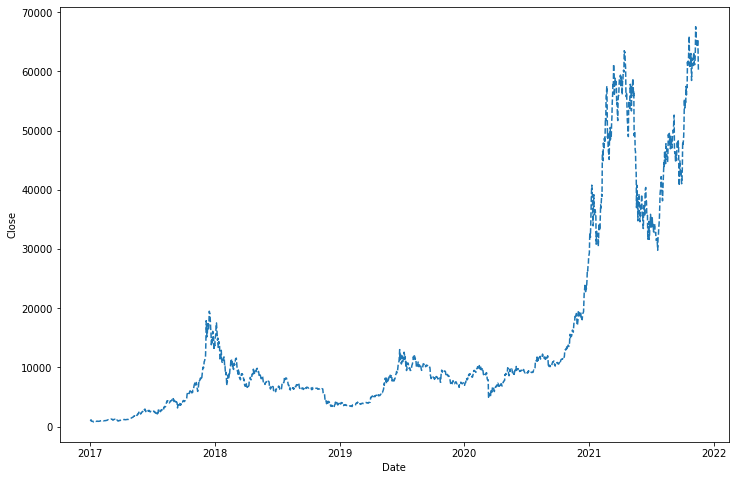

In [13]:
plt.figure(figsize=(12,8))
sns.lineplot(data=data,x='Date',y='Close',linestyle='--')
plt.show()

## Prepare Data for NN

In [15]:
#-- Normalization
mm_scaler = MinMaxScaler()
sd_scaler = StandardScaler()

In [16]:
data[['Close_scaled']] = sd_scaler.fit_transform(data[['Close']])

In [17]:
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Close_scaled
0,2017-01-01,1003.080017,958.698975,963.658020,998.325012,147775008.0,998.325012,-0.840383
1,2017-01-02,1031.390015,996.702026,998.617004,1021.750000,222184992.0,1021.750000,-0.838938
2,2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,185168000.0,1043.839966,-0.837575
3,2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,344945984.0,1154.729980,-0.830735
4,2017-01-05,1191.099976,910.416992,1156.729980,1013.380005,510199008.0,1013.380005,-0.839454


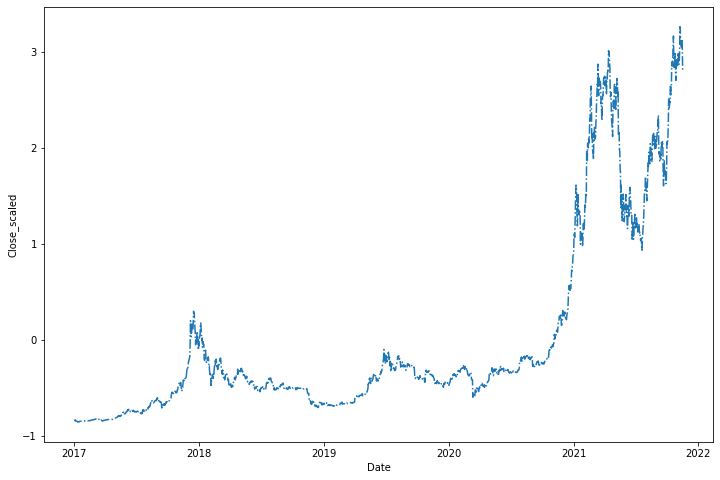

In [19]:
plt.figure(figsize=(12,8))
sns.lineplot(data=data,x='Date',y='Close_scaled',linestyle='-.')
plt.show()

In [72]:
scaled_close_prices = data['Close_scaled'].values.reshape(-1,1)
scaled_close_prices.shape

(1778, 1)

In [75]:
prediction_days=60
#x-train : 0-59 days, y_train : 1 day (60th day)

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_close_prices)):
    x_train.append(scaled_close_prices[x-prediction_days:x,0])
    y_train.append(scaled_close_prices[x,0])

In [76]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train_r = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
print(x_train_r.shape, y_train.shape)

(1718, 60, 1) (1718,)


## Model Building

In [78]:
model = models.Sequential()
model.add(layers.LSTM(units = 96, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(units = 96, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units = 96, return_sequences = False))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1,activation='relu'))

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 96)            37632     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 96)            74112     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [97]:
optim = tf.optimizers.Adam(learning_rate=0.0005)

In [98]:
model.compile(optimizer=optim,loss='mean_squared_error')

In [99]:
model.fit(x_train_r, y_train, epochs= 10, batch_size= 256)

Epoch 1/10
7/7 [==============================] - 21s 1s/step - loss: 0.2326
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 0.2312
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.2244
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.2192
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.2165
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.2147
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.2119
Epoch 8/10
7/7 [==============================] - 9s 1s/step - loss: 0.2136
Epoch 9/10
7/7 [==============================] - 10s 1s/step - loss: 0.2135
Epoch 10/10
7/7 [==============================] - 10s 1s/step - loss: 0.2122


## Model Testing

In [127]:
test_start =  dt.datetime.now() - dt.timedelta(days=30)
test_end = dt.datetime.now()

In [128]:
test_data = pd_reader.DataReader(f'{crypto}-{vs_currency}', 'yahoo', test_start, test_end)
test_data = test_data.reset_index()

In [129]:
scaled_close_prices_test = sd_scaler.transform(test_data['Close'].values.reshape(-1,1))

In [130]:
len(scaled_close_prices_test)

31

In [91]:
def model_infer(input_starting_60_days, prediction_length = 10, temprature = 0.01):
    last_60_data = input_starting_60_days
    predictions = []
    for i in range(prediction_length):
        daily_prediction = model(np.expand_dims(last_60_data, axis=0)).numpy() + (np.random.randn(1) * temprature)
        #print(daily_prediction)
        
        predictions.append(sd_scaler.inverse_transform(daily_prediction))
        last_60_data = np.vstack((last_60_data,daily_prediction ))[-60:]
    return predictions

In [104]:
predictions = model_infer(x_train_r[-1],prediction_length = 30,temprature=0.001) # last60days are used as start

In [141]:
full_data = pd.concat((data,test_data)).reset_index()


In [142]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1809 entries, 0 to 1808
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         1809 non-null   int64         
 1   Date          1809 non-null   datetime64[ns]
 2   High          1809 non-null   float64       
 3   Low           1809 non-null   float64       
 4   Open          1809 non-null   float64       
 5   Close         1809 non-null   float64       
 6   Volume        1809 non-null   float64       
 7   Adj Close     1809 non-null   float64       
 8   Close_scaled  1778 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 127.3 KB


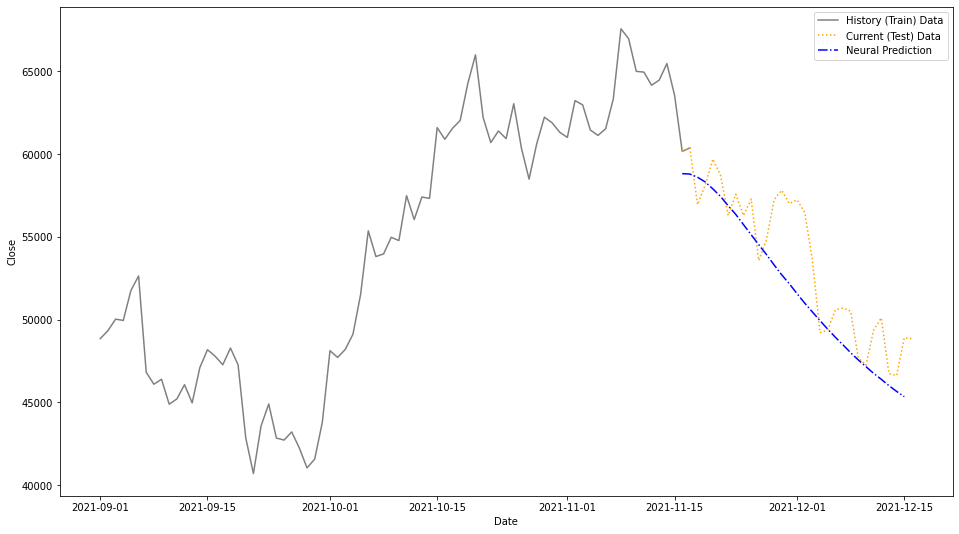

In [184]:
predictions_ = np.array(predictions).squeeze()

plt.figure(figsize=(16,9))

t_range = 1700
sns.lineplot(x=data.iloc[t_range:].Date,y= data.iloc[t_range:].Close,linestyle='-',color='gray', label='History (Train) Data')

sns.lineplot(x=test_data.Date,y= test_data.Close,linestyle=':',color='orange', label='Current (Test) Data')

sns.lineplot(x=test_data.iloc[0:len(predictions_),:].Date,y= predictions_,linestyle='-.',color='blue', label='Neural Prediction')
plt.show()

## Summary & Improvements

* The observable NN prediction matches the real price movement trend for up to 30 days!, but it might be due to the bearish market trend only not the model capability, the real test is when the market flips.
* We used a relatively simple LSTM model, we can try increasing model capacity, different architectures and techniques.